<a href="https://colab.research.google.com/github/rittin2803/Cryptonnect/blob/main/CREMA_Shift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  <center> Speech Emotion Recognition <center>

### I am going to build a speech emotion detection classifier.
### But first we need to learn about what is speech recognition (SER) and why are we building this project? Well, few of the reasons are-

#### First, lets define SER i.e. Speech Emotion Recognition.
* Speech Emotion Recognition, abbreviated as SER, is the act of attempting to recognize human emotion and affective states from speech. This is capitalizing on the fact that voice often reflects underlying emotion through tone and pitch. This is also the phenomenon that animals like dogs and horses employ to be able to understand human emotion.

#### Why we need it?

1. Emotion recognition is the part of speech recognition which is gaining more popularity and need for it increases enormously. Although there are methods to recognize emotion using machine learning techniques, this project attempts to use deep learning to recognize the emotions from data.

2. SER(Speech Emotion Recognition) is used in call center for classifying calls according to emotions and can be used as the performance parameter for conversational analysis thus identifying the unsatisfied customer, customer satisfaction and so on.. for helping companies improving their services

3. It can also be used in-car board system based on information of the mental state of the driver can be provided to the system to initiate his/her safety preventing accidents to happen

#### Datasets used in this project

* Crowd-sourced Emotional Mutimodal Actors Dataset (Crema-D)
* Ryerson Audio-Visual Database of Emotional Speech and Song (Ravdess)

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
#from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Data Preparation
* As we are working with four different datasets, so i will be creating a dataframe storing all emotions of the data in dataframe with their paths.
* We will use this dataframe to extract features for our model training.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
Ravdess = "/content/drive/MyDrive/Ravdess/audio_speech_actors_01-24/"
Crema = "/content/drive/MyDrive/Crema/"
Tess = "/content/drive/MyDrive/Tess/"

##  <center> 1. Ravdess Dataframe <center>
Here is the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4
This means the meta data for the audio file is:

* Video-only (02)
* Speech (01)
* Fearful (06)
* Normal intensity (01)
* Statement "dogs" (02)
* 1st Repetition (01)
* 12th Actor (12) - Female (as the actor ID number is even)

In [4]:
# ravdess_directory_list = os.listdir(Ravdess)

# file_emotion = []
# file_path = []
# for dir in ravdess_directory_list:
#     # as their are 20 different actors in our previous directory we need to extract files for each actor.
#     actor = os.listdir(Ravdess + dir)
#     for file in actor:
#         part = file.split('.')[0]
#         part = part.split('-')
#         # third part in each file represents the emotion associated to that file.
#         file_emotion.append(int(part[2]))
#         file_path.append(Ravdess + dir + '/' + file)

# # dataframe for emotion of files
# emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# # dataframe for path of files.
# path_df = pd.DataFrame(file_path, columns=['Path'])
# Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# # changing integers to actual emotions.
# Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
# Ravdess_df.head()

## <center>2. Crema DataFrame</center>

In [5]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

,Emotions,Path
0,happy,/content/drive/MyDrive/Crema/1079_TAI_HAP_XX.wav
1,neutral,/content/drive/MyDrive/Crema/1079_TSI_NEU_XX.wav
2,angry,/content/drive/MyDrive/Crema/1079_TIE_ANG_XX.wav
3,neutral,/content/drive/MyDrive/Crema/1079_TIE_NEU_XX.wav
4,sad,/content/drive/MyDrive/Crema/1079_TAI_SAD_XX.wav


In [6]:
# tess_directory_list = os.listdir(Tess)

# file_emotion = []
# file_path = []

# for dir in tess_directory_list:
#     directories = os.listdir(Tess + dir)
#     for file in directories:
#         part = file.split('.')[0]
#         part = part.split('_')[2]
#         if part=='ps':
#             file_emotion.append('surprise')
#         else:
#             file_emotion.append(part)
#         file_path.append(Tess + dir + '/' + file)

# # dataframe for emotion of files
# emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# # dataframe for path of files.
# path_df = pd.DataFrame(file_path, columns=['Path'])
# Tess_df = pd.concat([emotion_df, path_df], axis=1)
# Tess_df.head()

In [7]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Crema_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,happy,/content/drive/MyDrive/Crema/1079_TAI_HAP_XX.wav
1,neutral,/content/drive/MyDrive/Crema/1079_TSI_NEU_XX.wav
2,angry,/content/drive/MyDrive/Crema/1079_TIE_ANG_XX.wav
3,neutral,/content/drive/MyDrive/Crema/1079_TIE_NEU_XX.wav
4,sad,/content/drive/MyDrive/Crema/1079_TAI_SAD_XX.wav


## Data Visualisation and Exploration

First let's plot the count of each emotions in our dataset.

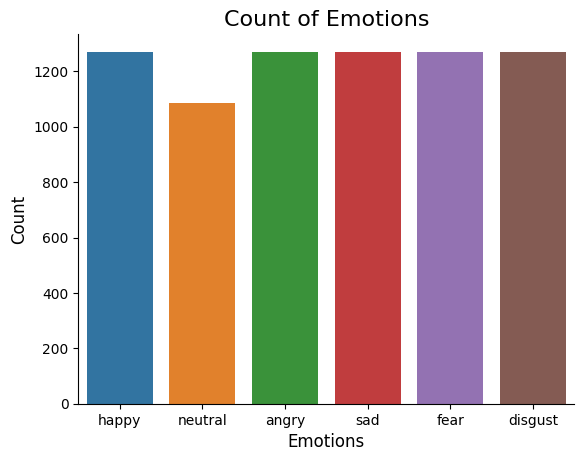

In [8]:
plt.title('Count of Emotions', size=16)
sns.countplot(x='Emotions', data=data_path)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

We can also plot waveplots and spectograms for audio signals

* Waveplots - Waveplots let us know the loudness of the audio at a given time.
* Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It’s a representation of frequencies changing with respect to time for given audio/music signals.

In [9]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    plt.plot(data)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

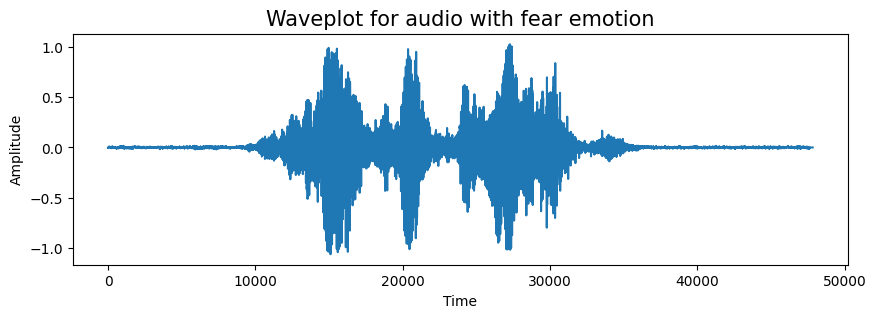

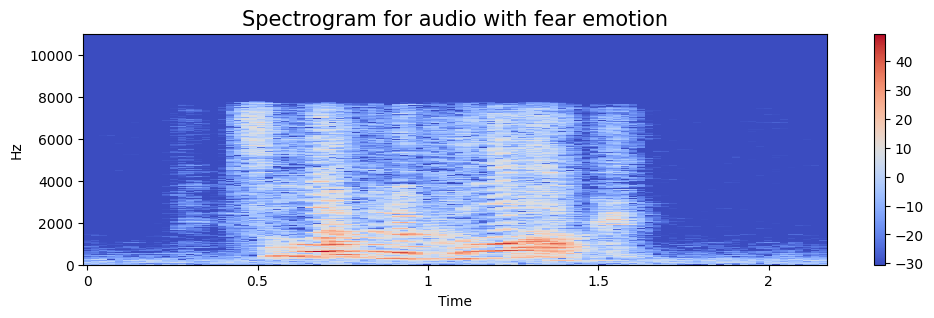

In [10]:
emotion = 'fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

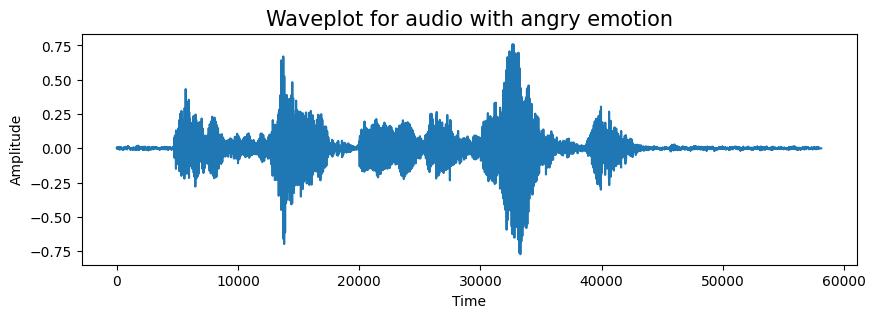

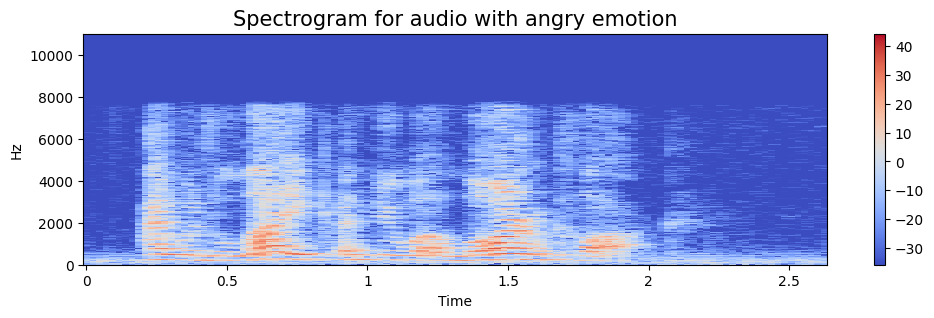

In [11]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

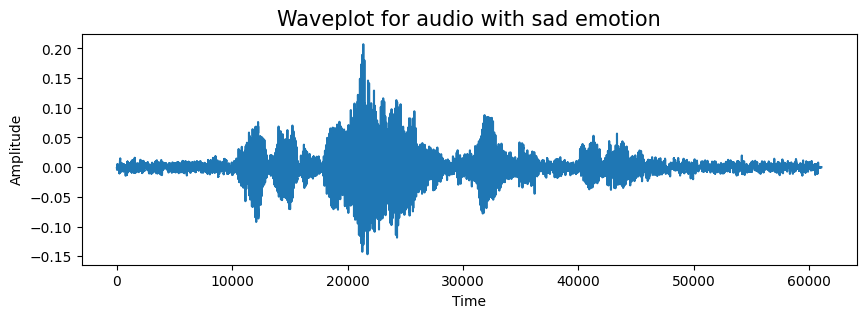

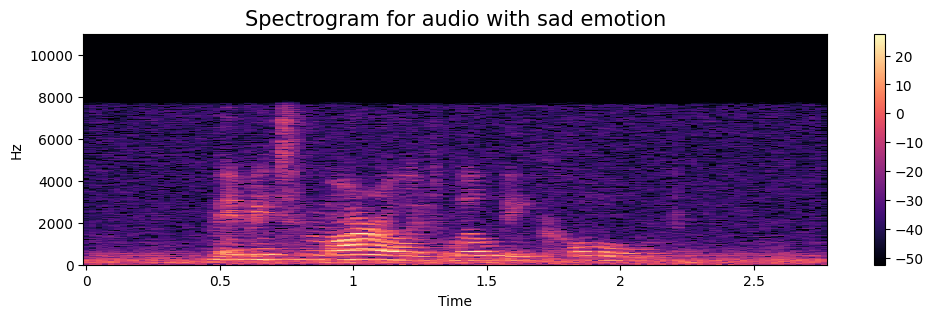

In [12]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

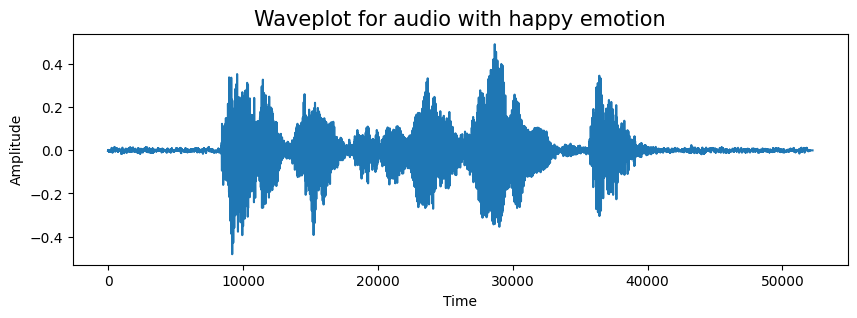

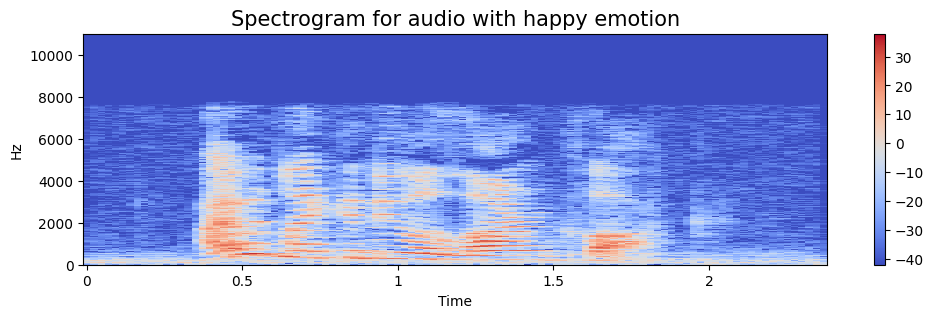

In [13]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data Augmentation

- Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.
- To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed.
- The objective is to make our model invariant to those perturbations and enhace its ability to generalize.
- In order to this to work adding the perturbations must conserve the same label as the original training sample.
- In images data augmention can be performed by shifting the image, zooming, rotating ...

First, let's check which augmentation techniques works better for our dataset.

In [14]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)



# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

#### 1. Simple Audio

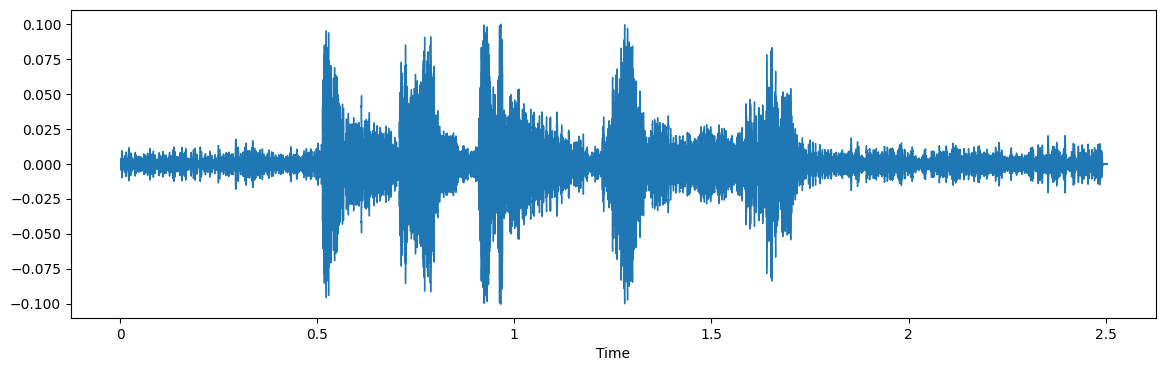

In [15]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

#### 2. Noise Injection

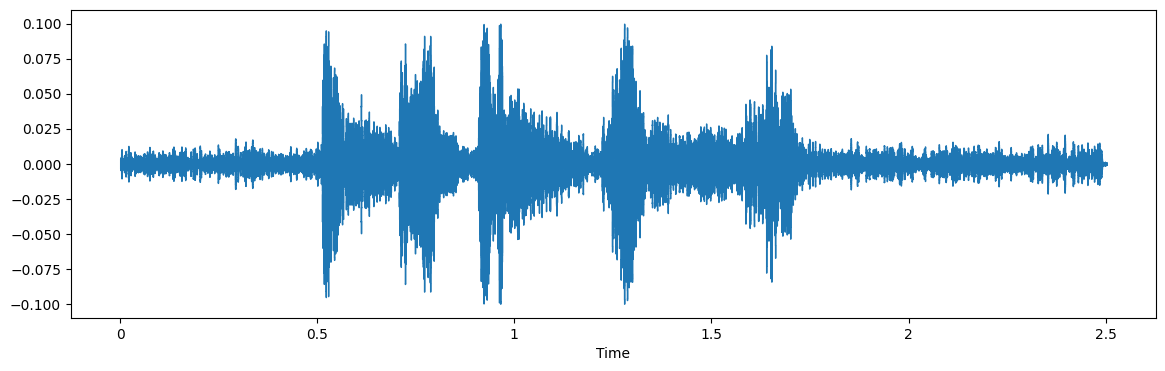

In [16]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

We can see noise injection is a very good augmentation technique because of which we can assure our training model is not overfitted

#### 3. Stretching

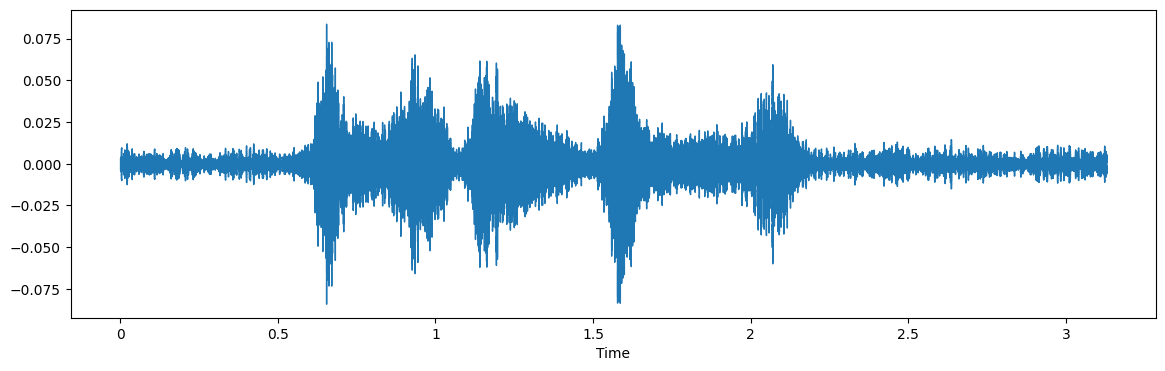

In [17]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 4. Shifting

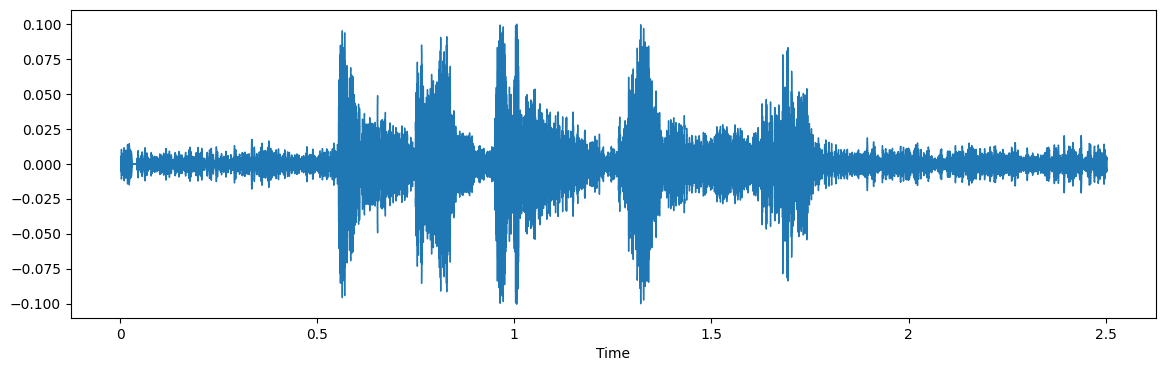

In [18]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

- From the above types of augmentation techniques i am using noise, stretching(ie. changing speed) and some pitching.

## Feature Extraction
- Extraction of features is a very important part in analyzing and finding relations between different things. As we already know that the data provided of audio cannot be understood by the models directly so we need to convert them into an understandable format for which feature extraction is used.


The audio signal is a three-dimensional signal in which three axes represent time, amplitude and frequency.

![image.png](https://miro.medium.com/max/633/1*7sKM9aECRmuoqTadCYVw9A.jpeg)

I am no expert on audio signals and feature extraction on audio files so i need to search and found a very good blog written by [Askash Mallik](https://medium.com/heuristics/audio-signal-feature-extraction-and-clustering-935319d2225) on feature extraction.

As stated there with the help of the sample rate and the sample data, one can perform several transformations on it to extract valuable features out of it.
1. Zero Crossing Rate : The rate of sign-changes of the signal during the duration of a particular frame.
2. Energy : The sum of squares of the signal values, normalized by the respective frame length.
3. Entropy of Energy : The entropy of sub-frames’ normalized energies. It can be interpreted as a measure of abrupt changes.
4. Spectral Centroid : The center of gravity of the spectrum.
5. Spectral Spread : The second central moment of the spectrum.
6. Spectral Entropy :  Entropy of the normalized spectral energies for a set of sub-frames.
7. Spectral Flux : The squared difference between the normalized magnitudes of the spectra of the two successive frames.
8. Spectral Rolloff : The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.
9.  MFCCs Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.
10. Chroma Vector : A 12-element representation of the spectral energy where the bins represent the 12 equal-tempered pitch classes of western-type music (semitone spacing).
11. Chroma Deviation : The standard deviation of the 12 chroma coefficients.


In this project i am not going deep in feature selection process to check which features are good for our dataset rather i am only extracting 5 features:
- Zero Crossing Rate
- Chroma_stft
- MFCC
- RMS(root mean square) value
- MelSpectogram to train our model.

In [19]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # # data with noise
    # noise_data = noise(data)
    # res2 = extract_features(noise_data)
    # result = np.vstack((result, res2)) # stacking vertically

    # # data with stretching and pitching
    # new_data = stretch(data)
    # res2 = extract_features(new_data)
    # result = np.vstack((result, res2)) # stacking vertically

    # Shifting
    new_data = shift(data)
    res2 = extract_features(new_data)
    result = np.vstack((result, res2))

    return result

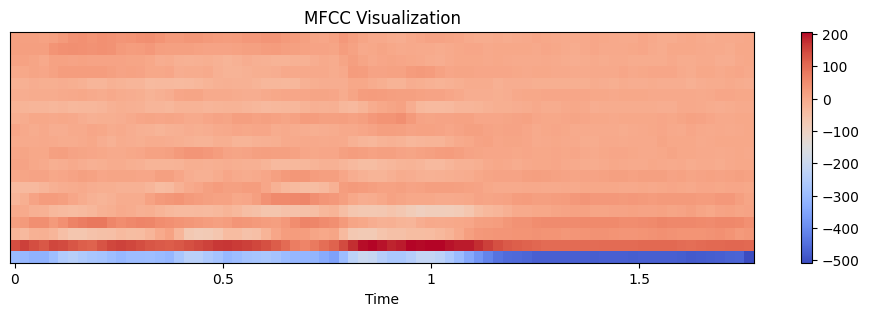

In [20]:
path = np.array(data_path.Path)[0]  # Replace [0] with the index of the clip you want to visualize

# Load the audio clip
data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

# Calculate MFCC features
mfcc = librosa.feature.mfcc(y=data, sr=sample_rate)

# Display the MFCC visualization
plt.figure(figsize=(12, 3))
plt.title('MFCC Visualization')
librosa.display.specshow(mfcc, sr=sample_rate, x_axis='time')
plt.colorbar()

# Save the visualization as an image if needed
plt.savefig('mfcc_visualization.png')

# Display the image if you want to show it in your research paper
plt.show()

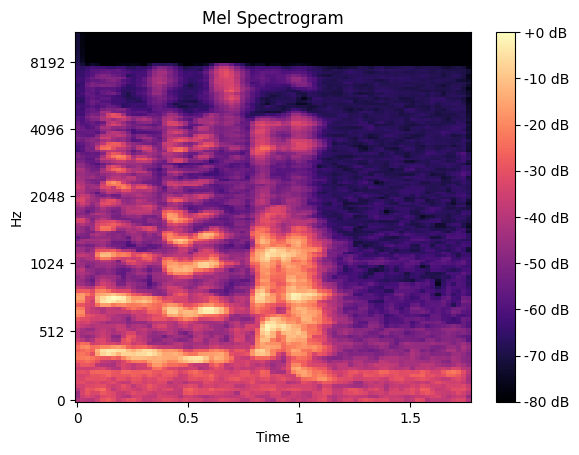

In [21]:
path = np.array(data_path.Path)[0]  # Replace [0] with the index of the clip you want to visualize

# Load the audio clip
data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
mel_spectrogram = librosa.feature.melspectrogram(y=data, sr=sampling_rate)

librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref=np.max), y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.show()

In [22]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [23]:
len(X), len(Y), data_path.Path.shape

(14884, 14884, (7442,))

In [24]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,141,142,143,144,145,146,147,148,149,labels
0,0.077440,-350.526093,134.588760,-7.151827,36.498703,-26.199999,15.931660,-3.200718,5.253214,-12.737644,...,1.772752e-07,1.641097e-07,1.547322e-07,1.477196e-07,1.424743e-07,1.386865e-07,1.359233e-07,1.341275e-07,1.330131e-07,happy
1,0.078689,-349.385773,135.176208,-7.615897,36.283264,-26.480431,15.685363,-3.668612,5.318666,-12.471598,...,2.236079e-07,2.076989e-07,1.963572e-07,1.878508e-07,1.814684e-07,1.768500e-07,1.734690e-07,1.712696e-07,1.698990e-07,happy
2,0.131246,-403.476807,117.208290,9.050887,64.802452,-15.443962,28.780931,-28.422277,17.629004,-12.544510,...,1.711906e-09,1.676875e-09,1.679097e-09,1.695098e-09,1.716100e-09,1.738830e-09,1.758562e-09,1.775285e-09,1.785109e-09,neutral
3,0.133432,-403.047638,117.036964,9.325319,64.581718,-15.660260,28.722450,-28.684153,17.671497,-12.537444,...,3.515110e-09,3.497019e-09,3.508009e-09,3.525345e-09,3.543742e-09,3.563411e-09,3.578987e-09,3.593120e-09,3.600223e-09,neutral
4,0.128007,-236.912308,102.032295,-33.281475,50.743950,-21.862106,6.555425,-17.713741,13.694263,-14.187608,...,1.842539e-09,1.621243e-09,1.460685e-09,1.339194e-09,1.246632e-09,1.177366e-09,1.125907e-09,1.090850e-09,1.069462e-09,angry


* We have applied data augmentation and extracted the features for each audio files and saved them.

## Data Preparation

- As of now we have extracted the data, now we need to normalize and split our data for training and testing.

In [25]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [26]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [27]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((11163, 150), (11163, 6), (3721, 150), (3721, 6))

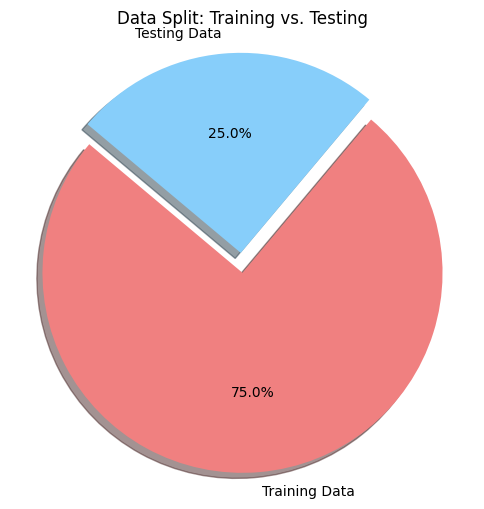

In [28]:
import matplotlib.pyplot as plt

# Assuming you have already split your data into x_train, x_test, y_train, and y_test

# Calculate the sizes of the training and testing sets
train_size = len(x_train)
test_size = len(x_test)

# Create a pie chart to visualize the data split
labels = ['Training Data', 'Testing Data']
sizes = [train_size, test_size]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)  # Explode the first slice (Training Data)

plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that the pie chart is circular.

# Add a title
plt.title('Data Split: Training vs. Testing')

# Show the chart
plt.show()

In [29]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((11163, 150), (11163, 6), (3721, 150), (3721, 6))

In [30]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((11163, 150, 1), (11163, 6), (3721, 150, 1), (3721, 6))

## Modelling

In [31]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=6, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 150, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1  (None, 75, 256)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 75, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 38, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 38, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 19, 128)           0

In [37]:
rlrp = ReduceLROnPlateau(monitor='val_accuracy', factor=0.4, verbose=0, patience=2, min_lr=0.00001)
history=model.fit(x_train, y_train, batch_size=128, epochs=20, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/20
88/88 [==============================] - 67s 762ms/step - loss: 0.7425 - accuracy: 0.7221 - val_loss: 1.0351 - val_accuracy: 0.6178 - lr: 1.0000e-05
Epoch 2/20
88/88 [==============================] - 65s 735ms/step - loss: 0.7433 - accuracy: 0.7278 - val_loss: 1.0336 - val_accuracy: 0.6195 - lr: 1.0000e-05
Epoch 3/20
88/88 [==============================] - 65s 730ms/step - loss: 0.7397 - accuracy: 0.7261 - val_loss: 1.0329 - val_accuracy: 0.6195 - lr: 1.0000e-05
Epoch 4/20
88/88 [==============================] - 64s 729ms/step - loss: 0.7353 - accuracy: 0.7236 - val_loss: 1.0337 - val_accuracy: 0.6187 - lr: 1.0000e-05
Epoch 5/20
88/88 [==============================] - 68s 769ms/step - loss: 0.7373 - accuracy: 0.7277 - val_loss: 1.0325 - val_accuracy: 0.6224 - lr: 1.0000e-05
Epoch 6/20
88/88 [==============================] - 70s 802ms/step - loss: 0.7483 - accuracy: 0.7257 - val_loss: 1.0330 - val_accuracy: 0.6221 - lr: 1.0000e-05
Epoch 7/20
88/88 [======================

117/117 [==============================] - 5s 41ms/step - loss: 1.0292 - accuracy: 0.6232
Accuracy of our model on test data :  62.32195496559143 %


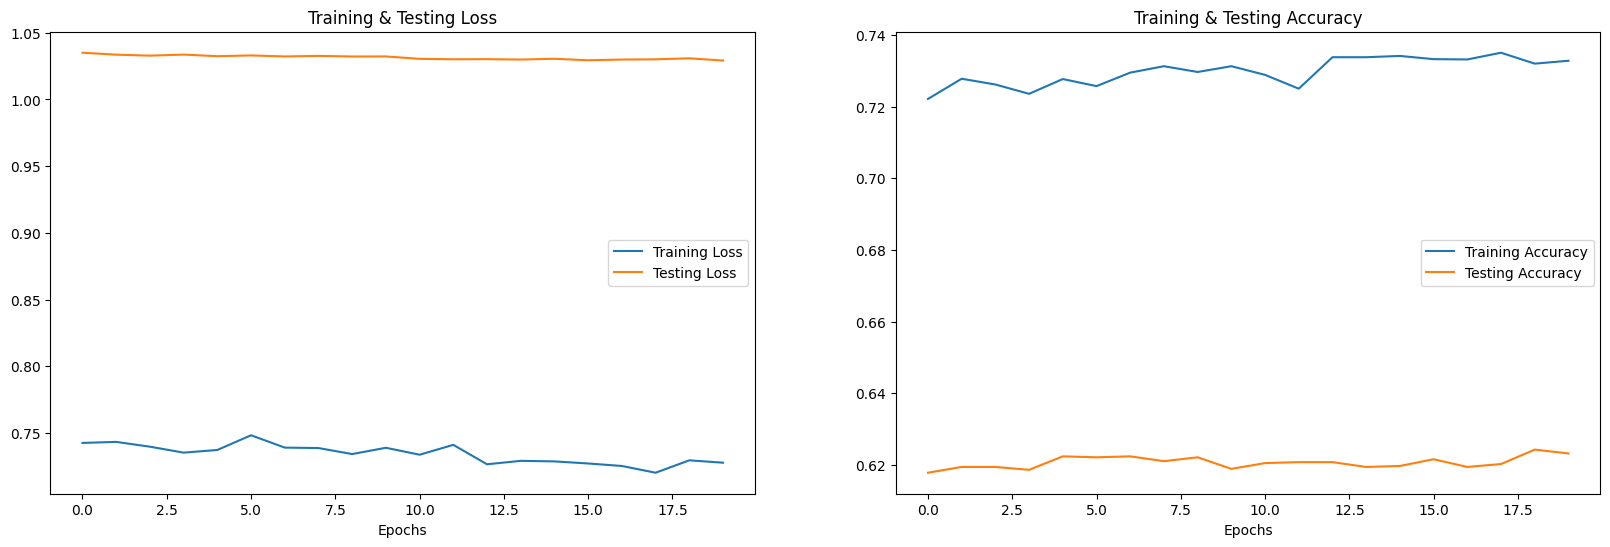

In [38]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [39]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

117/117 [==============================] - 7s 61ms/step


In [40]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,happy,happy
1,angry,happy
2,angry,angry
3,fear,fear
4,happy,happy
5,angry,angry
6,angry,angry
7,fear,happy
8,sad,sad
9,happy,happy


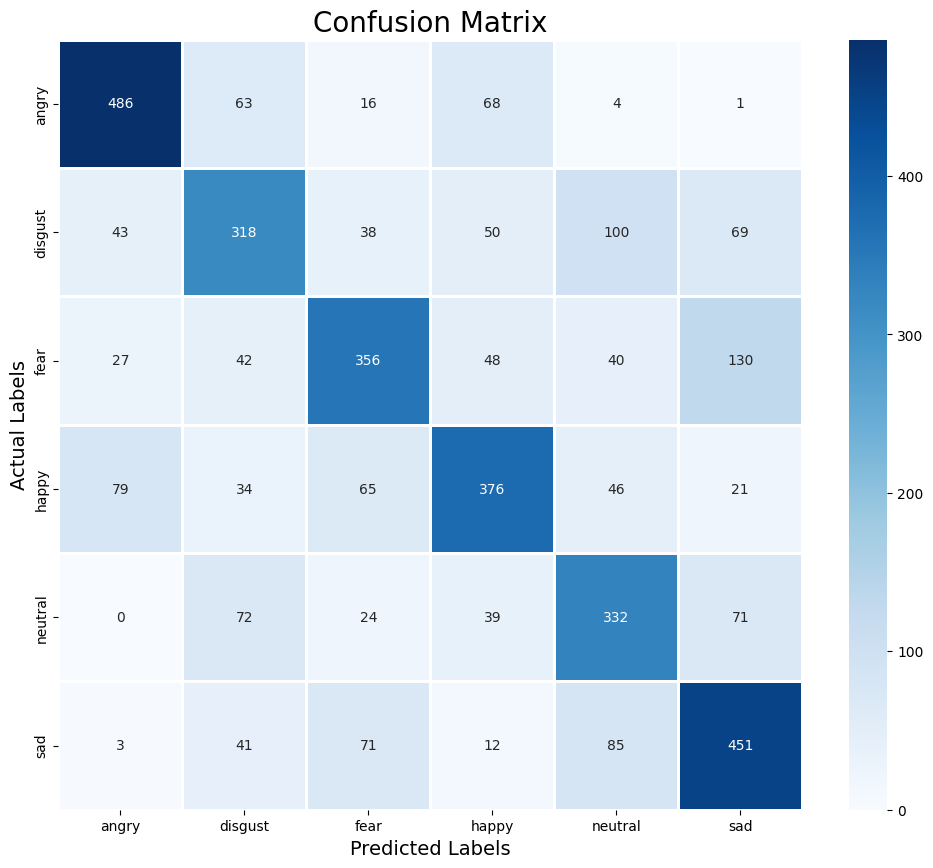

In [41]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [42]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.76      0.76      0.76       638
     disgust       0.56      0.51      0.54       618
        fear       0.62      0.55      0.59       643
       happy       0.63      0.61      0.62       621
     neutral       0.55      0.62      0.58       538
         sad       0.61      0.68      0.64       663

    accuracy                           0.62      3721
   macro avg       0.62      0.62      0.62      3721
weighted avg       0.62      0.62      0.62      3721

